In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class FederatedManager:

    def __init__(self, 
                 name,
                 dataloaders, 
                 test,
                 make_model,
                 loss_fn=nn.CrossEntropyLoss(), 
                 n_epochs=1, 
                 lr=1e-2, 
                 verbose=False, 
                 *args, **kwargs):
        
        self.dataloaders = dataloaders
        self.n_workers = len(dataloaders)
        self.n_epochs = n_epochs
        self.lr = lr
        self.verbose = verbose
        self.name = name
        self.history = {"test_loss": [], "test_acc": []}
        self.make_model = make_model
        self.model = self.make_model()
        self.model.train(False)
        self.loss_fn = loss_fn
        self.Xtest, self.ytest = consume_dataset(test)
        self.workers = []
        for i, dl in enumerate(dataloaders):
            self.workers.append(FederatedWorker(i, 
                                                self, 
                                                dl, 
                                                loss_fn,
                                                n_epochs=n_epochs, 
                                                lr=lr, 
                                                verbose=verbose,
                                                *args,
                                                **kwargs))
        self.worker_loss_histories = [[] for _ in self.workers]

    def round(self):
        """
        Do a round of federated learning:
         - instruct each worker to train and return its model
         - replace the server model the weighted average of the worker models
         - replace the worker models with the server model
        Workers with `participant=False` train but are not included in the
        weighted average and do not receive a copy of the server model.
        """
        updates = [w.train() for w in self.workers]
        self.fedavg(
            [u for u, w in zip(updates, self.workers) if w.participant]
        )
        self.push_model(w for w in self.workers if w.participant)
        self.record_loss()

    def fedavg(self, updates):
        """
        Replace the manager model with the weighted average of the node models.
        """
        N = sum(u["n_samples"] for u in updates)
        for key, value in self.model.state_dict().items():
            weight_sum = (
                u["state_dict"][key] * u["n_samples"] for u in updates
            )
            value[:] = sum(weight_sum) / N

    def push_model(self, workers):
        """
        Push manager model to a list of workers.
        """
        for worker in workers:
            worker.model = self.copy_model()

    def copy_model(self):
        """
        Return a copy of the current manager model.
        """
        model_copy = self.make_model()
        model_copy.load_state_dict(self.model.state_dict())
        return model_copy

    def evaluate_model(self, model=None):
        """
        Compute the loss and accuracy of model on test set.
        """
        model = model or self.model
        was_training = model.training
        model.train(False)
        with torch.no_grad():
            output = model(self.Xtest)
            loss = self.loss_fn(output, self.ytest).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(self.ytest.view_as(pred)).sum().item()
        model.train(was_training)
        return loss, 100. * correct / len(self.ytest)

    def record_loss(self):
        """
        Record loss of manager model and all worker models on test set.
        """
        loss_accuracy = self.evaluate_model()
        self.history["test_loss"].append(loss_accuracy[0])
        self.history["test_acc"].append(loss_accuracy[1])

In [2]:
class FederatedWorker:

    def __init__(
        self, name, manager, dataloader, loss_fn, n_epochs=1, lr=1e-2,
        momentum=0.5, participant=True, verbose=False
    ):
        self.name = name
        self.manager = manager
        self.dataloader = dataloader
        self.n_epochs = n_epochs
        self.loss_fn = loss_fn
        self.participant = participant
        self.model = manager.copy_model()
        self.n_samples = len(self.dataloader.dataset)
        self.history = {"train_loss": [], "test_loss": [], "test_acc": []}
        self.lr = lr
        self.momentum = momentum
        self.verbose = verbose

    def train(self):
        """
        Train for n_epochs, then return the state dictionary of the model and
        the amount of training data used.
        """
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr,
                                    momentum=self.momentum)
        self.model.train(True)
        for epoch in range(self.n_epochs):
            for i, (x, y) in enumerate(self.dataloader):
                optimizer.zero_grad()
                ypred = self.model(x)
                train_loss = self.loss_fn(ypred, y)
                train_loss.backward()
                optimizer.step()
                self.history["train_loss"].append(train_loss.item())

        loss_accuracy = self.manager.evaluate_model(self.model)
        self.history["test_loss"].append(loss_accuracy[0])
        self.history["test_acc"].append(loss_accuracy[1])
        
        if(self.verbose):
            print(
                '\twrkr {}\t\tloss: {:.4f}\tacc: {:.2%}'.format(
                    self.name,
                    self.history["test_loss"][-1],
                    self.history["test_acc"][-1] / 100,
                )
            )

        return {
            "state_dict": self.model.state_dict(),
            "n_samples": self.n_samples
        }

In [3]:
'''   

# THIS IS THE OFFICIAL PYTORCH EXAMPLE, BUT IT'S SLOWER THAN THE OTHER MODEL, SO FOR NOW, IT'S FAST BEFORE TIDY

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
'''

# Quick and gets the job done well enough for testing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#'''

In [4]:
from torch.utils.data import Subset

def make_fed_dloaders(dset, p=None, batch_size=64, shuffle=True):
    
    return [DataLoader(dset, batch_size, shuffle) for dset in make_fed_dsets(dset, p=p)]
    
def make_fed_dsets(dset, p=None):
    _, y = consume_dataset(dset)
    classes = set(y.numpy())
    n_classes = len(classes)
    idx_dset = index_to_dataset(y, p=p)
    dset_idx = [np.where(idx_dset == di)[0] for di in range(n_classes)]
    return [Subset(dset, di) for di in dset_idx]

def index_to_dataset(y, p=None):
    classes = set(y.numpy())
    n_classes = len(classes)
    p = p or 1/n_classes
    pnot = (1-p)/(n_classes-1)
    ps = np.full((n_classes, n_classes), pnot)
    np.fill_diagonal(ps, p)
    return np.array([np.random.choice(10, p=ps[yi]) for yi in y])

def check_dsets(dsets):
    for dset in dsets:
        _, y = consume_dataset(dset)
        print(Counter(y.numpy()))

def eval_new_mgr(name, train_dset, test_dset, p=0.0, n_rounds=50, target_acc=None, net=Net):
    dls = make_fed_dloaders(train_dset, p=p)
    mgr = FederatedManager(name, dls, test_dset, net)
    run_mgr(mgr, n_rounds, target_acc)
    plot_mgr(mgr)
    return mgr

In [5]:
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from collections import Counter
import numpy as np

def plot_digit_histogram(dls, title=''):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_ylabel('Digit Samples')
    ax.set_xlabel('Digit')
    
    ys = []
    for dset in tqdm([dl.dataset for dl in dls], desc='Tabulating datasets'):
        _, y = consume_dataset(dset)
        ys.append(sorted(Counter(y)))
        
    H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

def consume_dataset(dataset):
    data = list(zip(*dataset))
    X = torch.stack(data[0])
    y = torch.tensor(data[1])
    return X, y

In [6]:
def run_mgr(mgr, n_rounds=10, target_acc=None):
    
    target_met = False;
    
    if (target_acc):
        print('{} manager training with {} worker(s) for up to {} rounds or {:.2%} accuracy.'.format(
                mgr.name, mgr.n_workers, n_rounds, target_acc / 100,))
    else:
        print('{} manager training with {} worker(s) for {} rounds.'.format(
                mgr.name, mgr.n_workers, n_rounds,))

    for i in trange(n_rounds, desc='Rounds'):
        if(mgr.verbose):
            print('Round', i)
        mgr.round()
        if(mgr.verbose):
            print('\tcombined\tloss: {:.4f}\tacc: {:.2%}\n'.format(
                mgr.history['test_loss'][-1], mgr.history['test_acc'][-1] / 100,))
            
        if(target_acc and (mgr.history['test_acc'][-1] >= target_acc)):
            target_met = True
            break;

    if(target_met):
        print('{} manager stopped: met accuracy target of {:.2%} after {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name, target_acc / 100, len(mgr.history['test_acc']), mgr.history['test_acc'][-1] / 100, mgr.history['test_loss'][-1],))
    else:
        print('{} manager trained {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name, len(mgr.history['test_acc']), mgr.history['test_acc'][-1] / 100, mgr.history['test_loss'][-1],))

def plot_mgr(mgrs, plot_workers=False):
    
    if not isinstance(mgrs, list):
        mgrs = [mgrs]
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_loss'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_loss'], label=(m.name, 'Worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend();
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_acc'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_acc'], label=(m.name, 'worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Accuracy")
    ax.legend();

    

In [7]:
def show_prediction(img, preds, correct_idx):
    
    preds = preds.data.numpy().squeeze()
    
    colors = ['blue'] * len(preds)
    colors[preds.argmax()] = 'red'
    colors[correct_idx] = 'green'

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())

    ax2.bar(range(10), preds, color=colors)
    ax2.set_aspect(0.25)
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(range(10))
    ax2.set_title('log(likelihood)')
    ax2.set_ylim(-20, 20)
    plt.tight_layout()

def get_eval_set(mgr):
    with torch.no_grad():
        output = mgr.model(mgr.Xtest)
    preds = output.argmax(dim=1, keepdim=True)
    return [{'x':mgr.Xtest[i],
             'probs':output[i],
             'pred':preds[i].item(),
             'y':mgr.ytest[i].item(),
             } for i in range(len(mgr.Xtest))]

def confusion_matrix(eval_set, norm=False, mirror=False):
    cm = np.zeros((10, 10))
    for ev in eval_set:
        cm[ev['y']][ev['pred']] += 1
        if mirror:
            cm[ev['pred']][ev['y']] += 1 # will amplify errors and remove directionality of error
    if norm:
        cm /=  cm.sum(axis=1)[:,np.newaxis]
    return cm

def show_model_confusion(mgr):
    eval_set = get_eval_set(mgr)
    misses = [ev for ev in eval_set if (ev['y'] != ev['pred'])]
    cm = confusion_matrix(misses, norm=False, mirror=True)
    #cm = np.log1p(cm)
    #print(np.array_str(cm, precision=4, suppress_small=True))
    plt.imshow(cm)
    plt.tight_layout()
    
def count_dsets(dsets, show_array=False, show_heatmap=False):
    cts = []
    for dset in tqdm(dsets, desc='Counting examples'):
        _, y = consume_dataset(dset)
        c = Counter(y.numpy())
        #print([c[i] for i in range(len(c))])
        cts.append([c[i] for i in range(len(c))])
    
    cts = np.array(cts)
    
    if show_array:
        print(cts)
        
    if show_heatmap:
        plt.imshow(np.log1p(cts), norm=plt.Normalize(vmin= 0.0, vmax=np.log1p(cts.sum())));
        plt.tight_layout();
        
    return np.array(cts)

# Common Data and Hyperparameters

In [8]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

data_path = './MNIST-data/raw'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [9]:
from torch.utils.data import DataLoader

train_batch_size = 256
test_batch_size = 1000

# create standard dataloaders using all of the MNIST data
train_dl = DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
test_dl = DataLoader(test_dset, batch_size=test_batch_size, shuffle=True)

In [10]:
# default training targets
default_n_rounds = 2
default_target_acc = 90.0

# Non-Federated

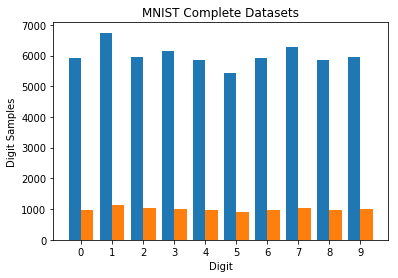

In [11]:
plot_digit_histogram([train_dl, test_dl], 'MNIST Complete Datasets')


[[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]]


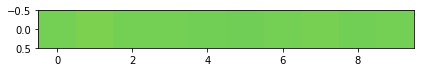

In [12]:
train_counts = count_dsets([train_dl.dataset], show_array=True, show_heatmap=True)

Non-Federated Full Dataset manager training with 1 worker(s) for up to 2 rounds or 90.00% accuracy.


Non-Federated Full Dataset manager stopped: met accuracy target of 90.00% after 2 rounds. (Test accuracy 90.66% and loss 0.3245.)


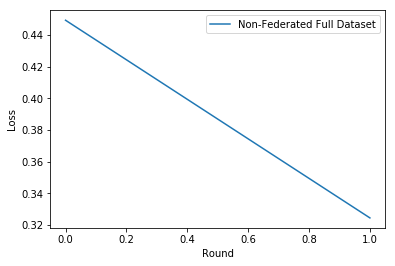

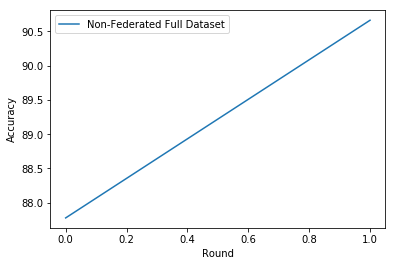

In [13]:
nonfed_alldata_mgr = FederatedManager('Non-Federated Full Dataset', [train_dl], test_dset, Net)

run_mgr(nonfed_alldata_mgr, default_n_rounds, target_acc=default_target_acc)

plot_mgr(nonfed_alldata_mgr)

# The Federated Approach

## Ten Equal Workers

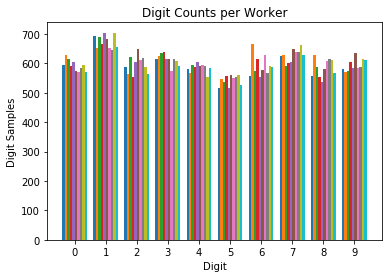

In [14]:
fed_equal_dls = make_fed_dloaders(train_dset)
plot_digit_histogram(fed_equal_dls, 'Digit Counts per Worker')


[[595 692 587 614 579 516 557 626 558 581]
 [629 652 562 626 566 547 664 627 629 572]
 [614 691 620 634 593 536 575 592 589 574]
 [591 665 553 640 588 558 615 602 554 606]
 [603 702 606 613 606 516 554 604 537 584]
 [575 681 649 615 590 560 577 648 580 635]
 [570 653 611 573 594 549 627 638 609 583]
 [584 646 618 616 590 553 568 640 616 588]
 [593 704 589 609 552 560 592 661 611 616]
 [569 656 563 591 584 526 589 627 568 610]]


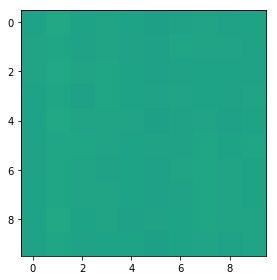

In [15]:
fed_equal_counts = count_dsets([dl.dataset for dl in fed_equal_dls], show_array=True, show_heatmap=True)

In [16]:
fed_equal_mgr = FederatedManager('Federated Unbiased', fed_equal_dls, test_dset, Net)

run_mgr(fed_equal_mgr, default_n_rounds, default_target_acc)

Federated Unbiased manager training with 10 worker(s) for up to 2 rounds or 90.00% accuracy.



Federated Unbiased manager trained 2 rounds. (Test accuracy 87.23% and loss 0.5196.)


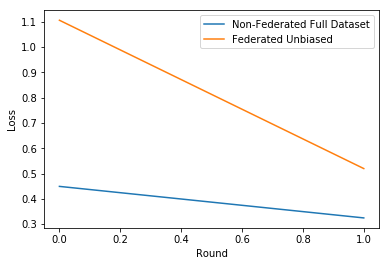

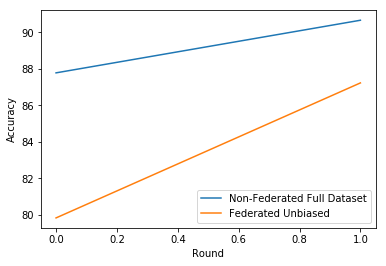

In [17]:
plot_mgr([nonfed_alldata_mgr, fed_equal_mgr])

# Federation with Varying Example Distributions Per Worker


## Spliting the Decks into Uneven Piles

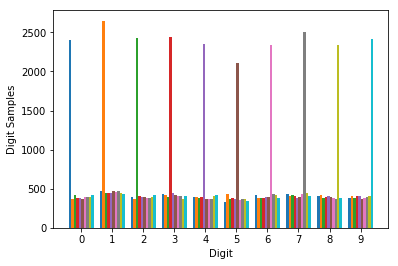

In [18]:
fed_weighted_dls = make_fed_dloaders(train_dset, p=0.4)
plot_digit_histogram(fed_weighted_dls)

In [19]:
check_dsets([dl.dataset for dl in fed_weighted_dls])

Counter({0: 2401, 1: 471, 7: 437, 3: 436, 6: 417, 8: 406, 4: 392, 2: 391, 9: 381, 5: 336})
Counter({1: 2649, 5: 434, 3: 420, 8: 414, 7: 411, 9: 401, 4: 392, 6: 384, 2: 372, 0: 368})
Counter({2: 2423, 1: 447, 7: 424, 0: 419, 3: 390, 9: 382, 4: 381, 6: 380, 8: 379, 5: 370})
Counter({3: 2439, 1: 446, 2: 410, 7: 408, 9: 405, 4: 391, 8: 390, 6: 384, 0: 380, 5: 376})
Counter({4: 2356, 3: 440, 1: 439, 9: 408, 8: 402, 6: 394, 2: 394, 7: 385, 0: 375, 5: 363})
Counter({5: 2106, 1: 472, 3: 422, 8: 399, 7: 399, 6: 393, 2: 392, 0: 372, 9: 368, 4: 365})
Counter({6: 2343, 1: 462, 7: 438, 3: 403, 0: 392, 2: 386, 9: 385, 8: 377, 4: 374, 5: 357})
Counter({7: 2508, 1: 473, 6: 428, 3: 411, 9: 398, 0: 396, 2: 380, 8: 373, 5: 371, 4: 368})
Counter({8: 2332, 7: 449, 1: 445, 6: 420, 4: 408, 9: 401, 0: 400, 2: 393, 3: 367, 5: 365})
Counter({9: 2420, 1: 438, 0: 420, 2: 417, 4: 415, 7: 406, 3: 403, 8: 379, 6: 375, 5: 343})


array([[595, 692, 587, 614, 579, 516, 557, 626, 558, 581],
       [629, 652, 562, 626, 566, 547, 664, 627, 629, 572],
       [614, 691, 620, 634, 593, 536, 575, 592, 589, 574],
       [591, 665, 553, 640, 588, 558, 615, 602, 554, 606],
       [603, 702, 606, 613, 606, 516, 554, 604, 537, 584],
       [575, 681, 649, 615, 590, 560, 577, 648, 580, 635],
       [570, 653, 611, 573, 594, 549, 627, 638, 609, 583],
       [584, 646, 618, 616, 590, 553, 568, 640, 616, 588],
       [593, 704, 589, 609, 552, 560, 592, 661, 611, 616],
       [569, 656, 563, 591, 584, 526, 589, 627, 568, 610]])

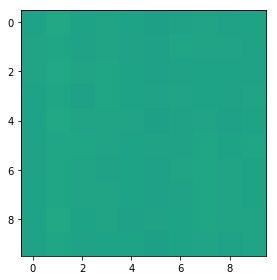

In [20]:
count_dsets([dl.dataset for dl in fed_equal_dls], show_array=False, show_heatmap=True)

array([[2401,  471,  391,  436,  392,  336,  417,  437,  406,  381],
       [ 368, 2649,  372,  420,  392,  434,  384,  411,  414,  401],
       [ 419,  447, 2423,  390,  381,  370,  380,  424,  379,  382],
       [ 380,  446,  410, 2439,  391,  376,  384,  408,  390,  405],
       [ 375,  439,  394,  440, 2356,  363,  394,  385,  402,  408],
       [ 372,  472,  392,  422,  365, 2106,  393,  399,  399,  368],
       [ 392,  462,  386,  403,  374,  357, 2343,  438,  377,  385],
       [ 396,  473,  380,  411,  368,  371,  428, 2508,  373,  398],
       [ 400,  445,  393,  367,  408,  365,  420,  449, 2332,  401],
       [ 420,  438,  417,  403,  415,  343,  375,  406,  379, 2420]])

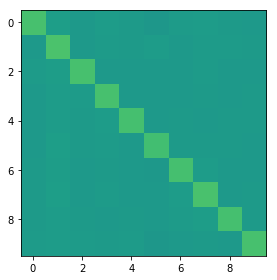

In [21]:
count_dsets([dl.dataset for dl in fed_weighted_dls], show_array=False, show_heatmap=True)

Fed Bias manager training with 10 worker(s) for up to 2 rounds or 90.00% accuracy.



Fed Bias manager trained 2 rounds. (Test accuracy 85.71% and loss 0.6184.)


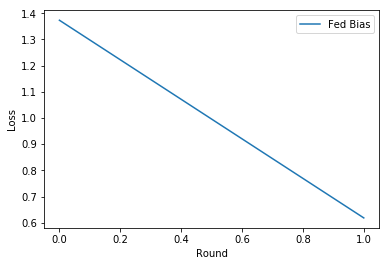

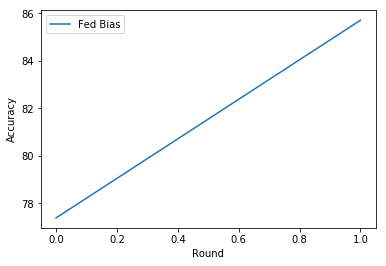

In [22]:
fed_weighted_mgr = FederatedManager('Fed Bias', fed_weighted_dls, test_dset, Net)
run_mgr(fed_weighted_mgr, default_n_rounds, default_target_acc)
plot_mgr(fed_weighted_mgr)

# Difficult Decisions

These matrices should show us which number pairs our model has trouble discriminating. (Spoiler alert: its 4-9 and 3-5 pairs. The 5-8-9 triplet looks troublesome, too.)

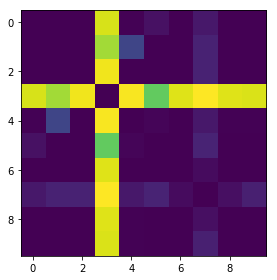

In [23]:
nonfed_alldata_mgr = FederatedManager('Non-Federated Full Dataset', [train_dl], test_dset, Net)

show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

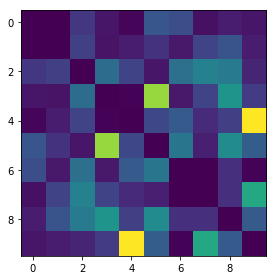

In [24]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

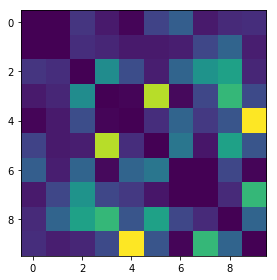

In [25]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

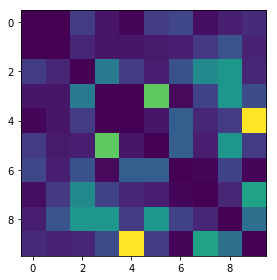

In [26]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

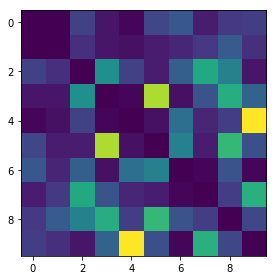

In [27]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

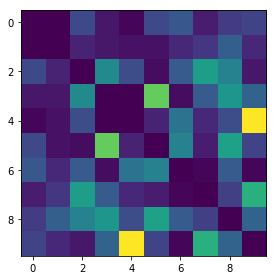

In [28]:
show_model_confusion(nonfed_alldata_mgr)
nonfed_alldata_mgr.round()

Let's see whether we can identify which digits give us the most trouble. Looks like 5, 8, and 9 are the most difficult.

In [29]:
eval_set = get_eval_set(nonfed_alldata_mgr)
misses = [ev for ev in eval_set if (ev['y'] != ev['pred'])]
cm = confusion_matrix(misses, norm=False, mirror=True)

print(cm)
print(sorted([(cm[i].sum(), i, cm[i].argmax()) for i in range(len(cm))]))

[[ 0.  0. 11.  3.  1. 14. 16.  5.  8. 12.]
 [ 0.  0.  6.  3.  2.  3.  7. 11. 17.  8.]
 [11.  6.  0. 28. 13.  2. 16. 35. 26.  3.]
 [ 3.  3. 28.  0.  1. 52.  1. 16. 31. 19.]
 [ 1.  2. 13.  1.  0.  4. 22.  8. 11. 56.]
 [14.  3.  2. 52.  4.  0. 23.  4. 30. 13.]
 [16.  7. 16.  1. 22. 23.  0.  1. 17.  1.]
 [ 5. 11. 35. 16.  8.  4.  1.  0. 11. 37.]
 [ 8. 17. 26. 31. 11. 30. 17. 11.  0.  9.]
 [12.  8.  3. 19. 56. 13.  1. 37.  9.  0.]]
[(57.0, 1, 8), (70.0, 0, 6), (104.0, 6, 5), (118.0, 4, 9), (128.0, 7, 9), (140.0, 2, 7), (145.0, 5, 3), (154.0, 3, 5), (158.0, 9, 4), (160.0, 8, 3)]


In [30]:
#TODO - Show the highest confidence picks

# Stacking the Deck Differently

make_fed_dloaders()

def make_custom_dsets(dset, n_workers=10, biases=[0.0]):
    
    dsets=[]
    
    
    
    return dls

In [34]:
n_workers = 7

_, y = consume_dataset(train_dset)
classes = set(y.numpy())
n_classes = len(classes)

ps = np.array([[1.0] * n_workers] * n_classes)

# Incorporate bias parameters here
ps[9][0] = 1e3 # relative allocation of '9's to worker 0
ps[4][0] = 1e3 # relative allocation of '4's to worker 0
#ps[2][2] = 7
#ps[4][7] = 2

print('ps\n', np.array_str(ps, precision=3))

for x in range(10000):
    ps = np.transpose(ps)
    ps = np.array([ps[i]/ps[i].sum() for i in range(len(ps))])
    ps = np.transpose(ps)
    ps = np.array([ps[i]/ps[i].sum() for i in range(len(ps))])

print('ps\n', np.array_str(ps, precision=3))
print([sum(ps[i]) for i in range(len(ps))])
print([sum([ps[j][i]for j in range(len(ps))]) for i in range(len(ps[0]))])

idx_dset = np.array([np.random.choice(n_workers, p=ps[yi]) for yi in y])
print('idx_dset', type(idx_dset), len(idx_dset), idx_dset)

dset_idx = [np.where(idx_dset == di)[0] for di in range(n_workers)]
print('dset lengths', [len(dset_idx[i]) for i in range(len(dset_idx))], '=', sum([len(dset_idx[i]) for i in range(len(dset_idx))]))

custom_dsets = [Subset(train_dset, di) for di in dset_idx]

check_dsets(custom_dsets)

ps
 [[   1.    1.    1.    1.    1.    1.    1.]
 [   1.    1.    1.    1.    1.    1.    1.]
 [   1.    1.    1.    1.    1.    1.    1.]
 [   1.    1.    1.    1.    1.    1.    1.]
 [1000.    1.    1.    1.    1.    1.    1.]
 [   1.    1.    1.    1.    1.    1.    1.]
 [   1.    1.    1.    1.    1.    1.    1.]
 [   1.    1.    1.    1.    1.    1.    1.]
 [   1.    1.    1.    1.    1.    1.    1.]
 [1000.    1.    1.    1.    1.    1.    1.]]
ps
 [[0.002 0.166 0.166 0.166 0.166 0.166 0.166]
 [0.002 0.166 0.166 0.166 0.166 0.166 0.166]
 [0.002 0.166 0.166 0.166 0.166 0.166 0.166]
 [0.002 0.166 0.166 0.166 0.166 0.166 0.166]
 [0.705 0.049 0.049 0.049 0.049 0.049 0.049]
 [0.002 0.166 0.166 0.166 0.166 0.166 0.166]
 [0.002 0.166 0.166 0.166 0.166 0.166 0.166]
 [0.002 0.166 0.166 0.166 0.166 0.166 0.166]
 [0.002 0.166 0.166 0.166 0.166 0.166 0.166]
 [0.705 0.049 0.049 0.049 0.049 0.049 0.049]]
[1.0, 1.0, 1.0, 1.0, 0.9999999999999996, 1.0, 1.0, 1.0, 1.0, 0.9999999999999996]
[1.428571

In [35]:
custom_dls = [DataLoader(dset, batch_size=256, shuffle=True) for dset in custom_dsets]

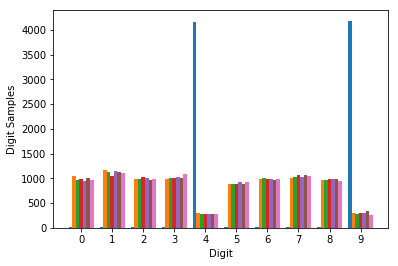

In [36]:
plot_digit_histogram(custom_dls)


[[  23   13   16   14 4151   14    7    8   20 4184]
 [1038 1163  980  992  291  875  984 1013  970  308]
 [ 964 1129  995  998  271  891 1001 1025  958  272]
 [ 985 1052 1022  999  283  894  988 1071  982  289]
 [ 948 1140 1002 1035  280  928  985 1024  982  300]
 [1006 1135  966 1002  278  895  964 1070  995  331]
 [ 959 1110  977 1091  288  924  989 1054  944  265]]


array([[  23,   13,   16,   14, 4151,   14,    7,    8,   20, 4184],
       [1038, 1163,  980,  992,  291,  875,  984, 1013,  970,  308],
       [ 964, 1129,  995,  998,  271,  891, 1001, 1025,  958,  272],
       [ 985, 1052, 1022,  999,  283,  894,  988, 1071,  982,  289],
       [ 948, 1140, 1002, 1035,  280,  928,  985, 1024,  982,  300],
       [1006, 1135,  966, 1002,  278,  895,  964, 1070,  995,  331],
       [ 959, 1110,  977, 1091,  288,  924,  989, 1054,  944,  265]])

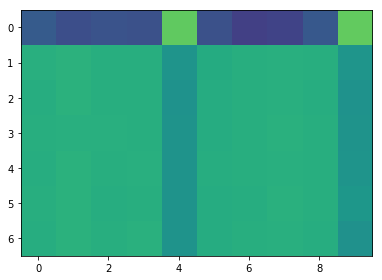

In [37]:
count_dsets([dl.dataset for dl in custom_dls], show_array=True, show_heatmap=True)

Custom 4-9 manager training with 7 worker(s) for up to 2 rounds or 90.00% accuracy.


Round 0
	wrkr 0		loss: 4.0497	acc: 16.46%
	wrkr 1		loss: 2.0320	acc: 58.25%
	wrkr 2		loss: 2.0303	acc: 59.81%
	wrkr 3		loss: 2.0331	acc: 60.18%
	wrkr 4		loss: 2.0337	acc: 61.18%
	wrkr 5		loss: 2.0311	acc: 59.24%
	wrkr 6		loss: 2.0331	acc: 60.79%
	combined	loss: 2.0318	acc: 60.85%

Round 1
	wrkr 0		loss: 3.8167	acc: 16.14%
	wrkr 1		loss: 1.5584	acc: 62.58%
	wrkr 2		loss: 1.5660	acc: 63.83%
	wrkr 3		loss: 1.5635	acc: 63.32%
	wrkr 4		loss: 1.5602	acc: 63.98%
	wrkr 5		loss: 1.5605	acc: 63.31%
	wrkr 6		loss: 1.5650	acc: 63.96%
	combined	loss: 1.5428	acc: 64.55%


Custom 4-9 manager trained 2 rounds. (Test accuracy 64.55% and loss 1.5428.)


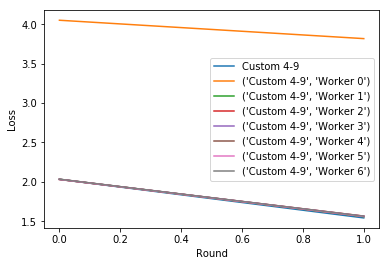

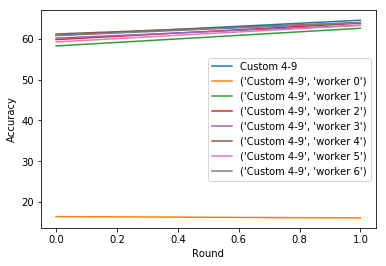

In [38]:
custom_mgr = FederatedManager('Custom 4-9', custom_dls, test_dset, Net, verbose = True)
run_mgr(custom_mgr, default_n_rounds, default_target_acc)
plot_mgr(custom_mgr, plot_workers=True)

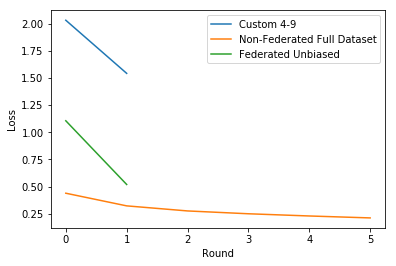

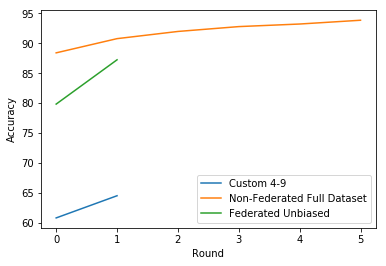

In [39]:
plot_mgr([custom_mgr, nonfed_alldata_mgr, fed_equal_mgr])

In [ ]:
#count_dsets(subsets, heatmap=True)

In [ ]:
def make_fed_dloaders(dset, p=None, batch_size=64, shuffle=True):
    
    return [DataLoader(dset, batch_size, shuffle) for dset in make_fed_dsets(dset, p=p)]
    
def make_fed_dsets(dset, p=None):
    _, y = consume_dataset(dset)
    classes = set(y.numpy())
    n_classes = len(classes)
    idx_dset = index_to_dataset(y, p=p)
    dset_idx = [np.where(idx_dset == di)[0] for di in range(n_classes)]
    return [Subset(dset, di) for di in dset_idx]

def index_to_dataset(y, p=None):
    classes = set(y.numpy())
    n_classes = len(classes)
    p = p or 1/n_classes
    pnot = (1-p)/(n_classes-1)
    ps = np.full((n_classes, n_classes), pnot)
    np.fill_diagonal(ps, p)
    return np.array([np.random.choice(10, p=ps[yi]) for yi in y])

### Some tinkering to display the outputs of an evaluation

Actual Digit:    7
Predicted Digit: 7 (9.40)
Nearest Digit  : 9 (6.68)
Farthest Digit : 6 (-7.27)


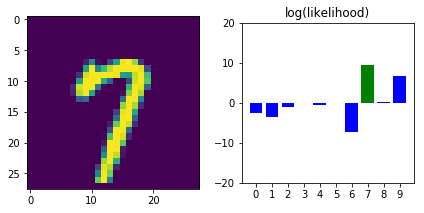

In [40]:
import random

xs, ys = next(iter(test_dl))

idx = random.randint(0, len(xs))

x = xs[idx]
y = ys[idx]

model = nonfed_alldata_mgr.model
with torch.no_grad():
    log_pred = model(x)

show_prediction(x, log_pred, y)

pred_vals = sorted(zip(range(10), log_pred[0].tolist()), key=lambda item: item[1], reverse=True)

print('Actual Digit:   ', y.item())
print('Predicted Digit: {:d} ({:.2f})'.format(pred_vals[0][0], pred_vals[0][1]))
print('Nearest Digit  : {:d} ({:.2f})'.format(pred_vals[1][0], pred_vals[1][1]))
print('Farthest Digit : {:d} ({:.2f})'.format(pred_vals[9][0], pred_vals[9][1]))

In [52]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", data_home="./scikit_learn_data/")

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(random_state=42,min_dist=0.8)
embedding = reducer.fit_transform(mnist.data)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=mnist.target, cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by UMAP 0.8", fontsize=18)

plt